In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv1D
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')

import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

from scipy import stats
from scipy.stats import norm, skew

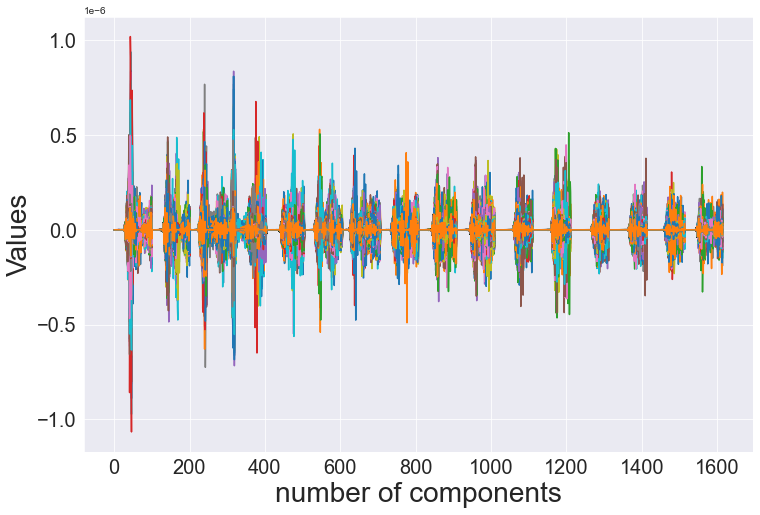

Response matrix shape:  (1616, 1602)


In [51]:
# ---------------------------------------------------------------------
# Data Management
# ---------------------------------------------------------------------

parameters_mat = scipy.io.loadmat('SFEM_BAE_MDL_MSH_PARAM.mat')
parameters_dataframe = pd.DataFrame(parameters_mat['PARAM'])

response_mat = scipy.io.loadmat('SFEM_BAE_MDL_MSH_40x40.mat')
response_dataframe = pd.DataFrame(response_mat['Y'])

plt.figure(figsize = (12, 8))
plt.plot(response_dataframe)
plt.xlabel('number of components', size = 28)
plt.ylabel('Values', size = 28)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.show()

print('Response matrix shape: ',response_dataframe.shape)

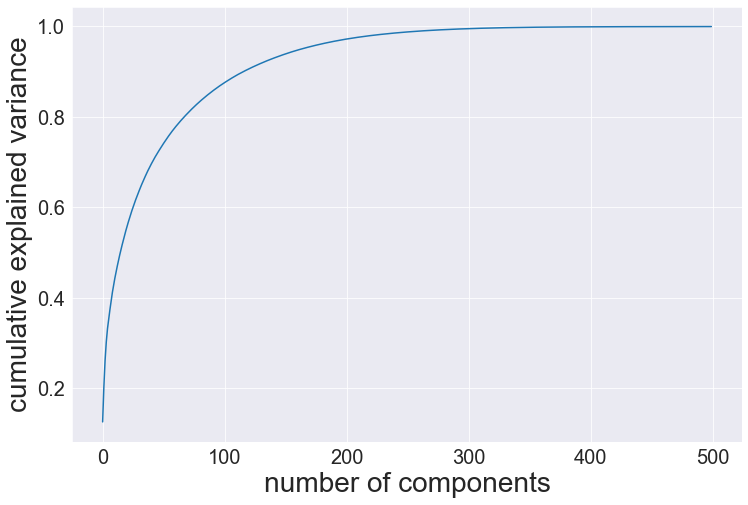

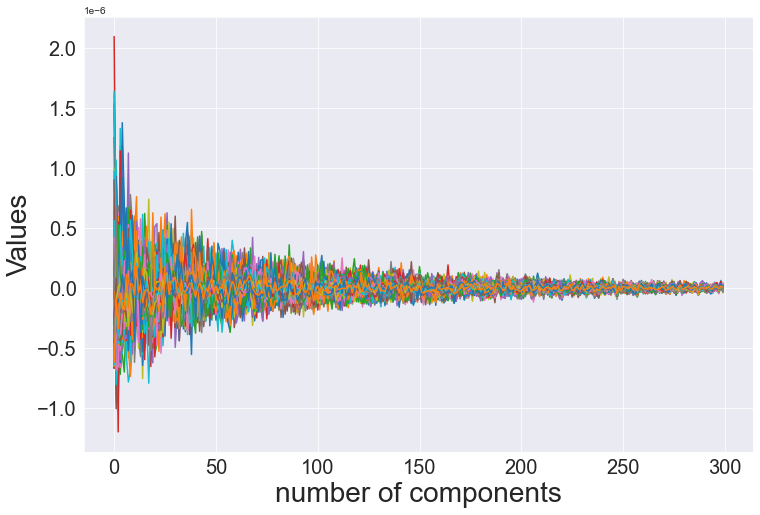

New response matrix shape:  (300, 1602)


In [52]:
# ---------------------------------------------------------------------
# Principal Component Analysis
# ---------------------------------------------------------------------

pca = PCA(n_components=500)
pca.fit(response_dataframe.T)
pca.components_.shape

plt.figure(figsize = (12, 8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components', size = 28)
plt.ylabel('cumulative explained variance', size = 28)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.show()

pca = PCA(n_components=300)
pca.fit(response_dataframe.T)

response_pca_dataframe = np.dot(pca.components_, response_dataframe)

plt.figure(figsize = (12, 8))
plt.plot(response_pca_dataframe)
plt.xlabel('number of components', size = 28)
plt.ylabel('Values', size = 28)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.show()

print('New response matrix shape: ', response_pca_dataframe.shape)

In [6]:
# ---------------------------------------------------------------------
# Data normalization
# ---------------------------------------------------------------------

parameters_dataframe.iloc[0,:] =(parameters_dataframe.iloc[0,:] -
                                 np.mean(parameters_dataframe.iloc[0,:])) / np.std(parameters_dataframe.iloc[0,:])
parameters_dataframe.iloc[1,:] =(parameters_dataframe.iloc[1,:] -
                                 np.mean(parameters_dataframe.iloc[1,:])) / np.std(parameters_dataframe.iloc[1,:])
parameters_dataframe.iloc[2,:] =(parameters_dataframe.iloc[2,:] -
                                 np.mean(parameters_dataframe.iloc[2,:])) / np.std(parameters_dataframe.iloc[2,:])
parameters_dataframe.iloc[3,:] =(parameters_dataframe.iloc[3,:] -
                                 np.mean(parameters_dataframe.iloc[3,:])) / np.std(parameters_dataframe.iloc[3,:])
parameters_dataframe.iloc[4,:] =(parameters_dataframe.iloc[4,:] -
                                 np.mean(parameters_dataframe.iloc[4,:])) / np.std(parameters_dataframe.iloc[4,:])

response_pca_dataframe = (response_pca_dataframe -
                                 np.mean(response_pca_dataframe)) / np.std(response_pca_dataframe)

In [14]:
# ---------------------------------------------------------------------
# Neural Network Architecture
# ---------------------------------------------------------------------

X = np.array(response_pca_dataframe.T)
y = np.array(parameters_dataframe.T)

seed = 10

dropout_rate = 0.3

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = seed)

initializer = tf.keras.initializers.LecunNormal()

model = Sequential()

model.add(Flatten())
model.add(Dense(np.shape(X)[1], kernel_initializer = 'he_uniform'))
model.add(Activation('relu'))
model.add(BatchNormalization())
    
model.add(Dropout(dropout_rate))
model.add(Dense(256, kernel_initializer = 'he_uniform'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Dropout(dropout_rate))
model.add(Dense(128, kernel_initializer = 'he_uniform'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Dropout(dropout_rate))
model.add(Dense(64, kernel_initializer = 'he_uniform'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Dropout(dropout_rate))
model.add(Dense(32, kernel_initializer = 'he_uniform'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Dropout(dropout_rate))
model.add(Dense(16, kernel_initializer = 'he_uniform'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Dropout(dropout_rate))
model.add(Dense(8, kernel_initializer = 'he_uniform'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Dropout(dropout_rate))
model.add(Dense(np.shape(y)[1], kernel_initializer = 'he_uniform'))
model.add(Activation('linear'))
model.add(BatchNormalization())

opt = tf.keras.optimizers.Adam(learning_rate = 0.0001, decay = 1e-6)

model.build(X_train.shape)

model.compile(loss = 'mse',
              optimizer = opt,
              metrics = ['mse'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (1281, 300)               0         
                                                                 
 dense_16 (Dense)            (1281, 300)               90300     
                                                                 
 activation_16 (Activation)  (1281, 300)               0         
                                                                 
 batch_normalization_16 (Bat  (1281, 300)              1200      
 chNormalization)                                                
                                                                 
 dropout_14 (Dropout)        (1281, 300)               0         
                                                                 
 dense_17 (Dense)            (1281, 256)               77056     
                                                      

C:\Users\berna\AppData\Local\Temp/ipykernel_6304/1068341468.py:7: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "training" failed type inference due to: Untyped global name 'model': Cannot determine Numba type of <class 'keras.engine.sequential.Sequential'>

File "..\..\..\..\AppData\Local\Temp\ipykernel_6304\1068341468.py", line 9:
<source missing, REPL/exec in use?>

  @jit


Epoch 1/10000
41/41 [==============================] - 2s 7ms/step - loss: 2.0175 - mse: 2.0175 - val_loss: 1.5427 - val_mse: 1.5427
Epoch 2/10000
41/41 [==============================] - 0s 3ms/step - loss: 1.9936 - mse: 1.9936 - val_loss: 1.2194 - val_mse: 1.2194
Epoch 3/10000
41/41 [==============================] - 0s 3ms/step - loss: 1.9318 - mse: 1.9318 - val_loss: 1.2315 - val_mse: 1.2315
Epoch 4/10000
41/41 [==============================] - 0s 3ms/step - loss: 1.9474 - mse: 1.9474 - val_loss: 1.2520 - val_mse: 1.2520
Epoch 5/10000
41/41 [==============================] - 0s 3ms/step - loss: 1.9174 - mse: 1.9174 - val_loss: 1.2630 - val_mse: 1.2630
Epoch 6/10000
41/41 [==============================] - 0s 3ms/step - loss: 1.9158 - mse: 1.9158 - val_loss: 1.2682 - val_mse: 1.2682
Epoch 7/10000
41/41 [==============================] - 0s 4ms/step - loss: 1.8699 - mse: 1.8699 - val_loss: 1.2739 - val_mse: 1.2739
Epoch 8/10000
41/41 [==============================] - 0s 3ms/step - 

41/41 [==============================] - 0s 3ms/step - loss: 1.1727 - mse: 1.1727 - val_loss: 0.9304 - val_mse: 0.9304
Epoch 63/10000
41/41 [==============================] - 0s 3ms/step - loss: 1.1848 - mse: 1.1848 - val_loss: 0.9261 - val_mse: 0.9261
Epoch 64/10000
41/41 [==============================] - 0s 3ms/step - loss: 1.1824 - mse: 1.1824 - val_loss: 0.9177 - val_mse: 0.9177
Epoch 65/10000
41/41 [==============================] - 0s 3ms/step - loss: 1.1932 - mse: 1.1932 - val_loss: 0.9094 - val_mse: 0.9094
Epoch 66/10000
41/41 [==============================] - 0s 3ms/step - loss: 1.1654 - mse: 1.1654 - val_loss: 0.9056 - val_mse: 0.9056
Epoch 67/10000
41/41 [==============================] - 0s 3ms/step - loss: 1.1572 - mse: 1.1572 - val_loss: 0.9104 - val_mse: 0.9104
Epoch 68/10000
41/41 [==============================] - 0s 3ms/step - loss: 1.1292 - mse: 1.1292 - val_loss: 0.9029 - val_mse: 0.9029
Epoch 69/10000
41/41 [==============================] - 0s 3ms/step - loss: 1

41/41 [==============================] - 0s 3ms/step - loss: 0.9118 - mse: 0.9118 - val_loss: 0.7569 - val_mse: 0.7569
Epoch 124/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.8979 - mse: 0.8979 - val_loss: 0.7567 - val_mse: 0.7567
Epoch 125/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.9052 - mse: 0.9052 - val_loss: 0.7584 - val_mse: 0.7584
Epoch 126/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.8855 - mse: 0.8855 - val_loss: 0.7591 - val_mse: 0.7591
Epoch 127/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.8892 - mse: 0.8892 - val_loss: 0.7556 - val_mse: 0.7556
Epoch 128/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.8870 - mse: 0.8870 - val_loss: 0.7556 - val_mse: 0.7556
Epoch 129/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.8855 - mse: 0.8855 - val_loss: 0.7529 - val_mse: 0.7529
Epoch 130/10000
41/41 [==============================] - 0s 3ms/step - 

Epoch 184/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.7819 - mse: 0.7819 - val_loss: 0.6857 - val_mse: 0.6857
Epoch 185/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.7861 - mse: 0.7861 - val_loss: 0.6864 - val_mse: 0.6864
Epoch 186/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.7770 - mse: 0.7770 - val_loss: 0.6859 - val_mse: 0.6859
Epoch 187/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.7650 - mse: 0.7650 - val_loss: 0.6851 - val_mse: 0.6851
Epoch 188/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.7779 - mse: 0.7779 - val_loss: 0.6854 - val_mse: 0.6854
Epoch 189/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.7721 - mse: 0.7721 - val_loss: 0.6828 - val_mse: 0.6828
Epoch 190/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.7676 - mse: 0.7676 - val_loss: 0.6813 - val_mse: 0.6813
Epoch 191/10000
41/41 [==============================] 

41/41 [==============================] - 0s 3ms/step - loss: 0.7111 - mse: 0.7111 - val_loss: 0.6451 - val_mse: 0.6451
Epoch 245/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.7274 - mse: 0.7274 - val_loss: 0.6438 - val_mse: 0.6438
Epoch 246/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.7176 - mse: 0.7176 - val_loss: 0.6425 - val_mse: 0.6425
Epoch 247/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.7185 - mse: 0.7185 - val_loss: 0.6396 - val_mse: 0.6396
Epoch 248/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.7236 - mse: 0.7236 - val_loss: 0.6405 - val_mse: 0.6405
Epoch 249/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.7180 - mse: 0.7180 - val_loss: 0.6408 - val_mse: 0.6408
Epoch 250/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.7176 - mse: 0.7176 - val_loss: 0.6432 - val_mse: 0.6432
Epoch 251/10000
41/41 [==============================] - 0s 3ms/step - 

Epoch 305/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.6951 - mse: 0.6951 - val_loss: 0.6205 - val_mse: 0.6205
Epoch 306/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.6953 - mse: 0.6953 - val_loss: 0.6202 - val_mse: 0.6202
Epoch 307/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.6940 - mse: 0.6940 - val_loss: 0.6185 - val_mse: 0.6185
Epoch 308/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.6892 - mse: 0.6892 - val_loss: 0.6196 - val_mse: 0.6196
Epoch 309/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.6936 - mse: 0.6936 - val_loss: 0.6181 - val_mse: 0.6181
Epoch 310/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.6932 - mse: 0.6932 - val_loss: 0.6180 - val_mse: 0.6180
Epoch 311/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.7024 - mse: 0.7024 - val_loss: 0.6186 - val_mse: 0.6186
Epoch 312/10000
41/41 [==============================] 

41/41 [==============================] - 0s 3ms/step - loss: 0.6699 - mse: 0.6699 - val_loss: 0.6051 - val_mse: 0.6051
Epoch 366/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.6793 - mse: 0.6793 - val_loss: 0.6052 - val_mse: 0.6052
Epoch 367/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.6824 - mse: 0.6824 - val_loss: 0.6043 - val_mse: 0.6043
Epoch 368/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.6678 - mse: 0.6678 - val_loss: 0.6024 - val_mse: 0.6024
Epoch 369/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.6651 - mse: 0.6651 - val_loss: 0.6040 - val_mse: 0.6040
Epoch 370/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.6718 - mse: 0.6718 - val_loss: 0.6060 - val_mse: 0.6060
Epoch 371/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.6781 - mse: 0.6781 - val_loss: 0.6071 - val_mse: 0.6071
Epoch 372/10000
41/41 [==============================] - 0s 3ms/step - 

Epoch 426/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.6638 - mse: 0.6638 - val_loss: 0.5966 - val_mse: 0.5966
Epoch 427/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.6692 - mse: 0.6692 - val_loss: 0.5986 - val_mse: 0.5986
Epoch 428/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.6578 - mse: 0.6578 - val_loss: 0.5970 - val_mse: 0.5970
Epoch 429/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.6591 - mse: 0.6591 - val_loss: 0.5931 - val_mse: 0.5931
Epoch 430/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.6527 - mse: 0.6527 - val_loss: 0.5890 - val_mse: 0.5890
Epoch 431/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.6643 - mse: 0.6643 - val_loss: 0.5906 - val_mse: 0.5906
Epoch 432/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.6610 - mse: 0.6610 - val_loss: 0.5933 - val_mse: 0.5933
Epoch 433/10000
41/41 [==============================] 

41/41 [==============================] - 0s 3ms/step - loss: 0.6455 - mse: 0.6455 - val_loss: 0.5845 - val_mse: 0.5845
Epoch 487/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.6453 - mse: 0.6453 - val_loss: 0.5903 - val_mse: 0.5903
Epoch 488/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.6526 - mse: 0.6526 - val_loss: 0.5886 - val_mse: 0.5886
Epoch 489/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.6556 - mse: 0.6556 - val_loss: 0.5867 - val_mse: 0.5867
Epoch 490/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.6504 - mse: 0.6504 - val_loss: 0.5880 - val_mse: 0.5880
Epoch 491/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.6422 - mse: 0.6422 - val_loss: 0.5873 - val_mse: 0.5873
Epoch 492/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.6475 - mse: 0.6475 - val_loss: 0.5870 - val_mse: 0.5870
Epoch 493/10000
41/41 [==============================] - 0s 3ms/step - 

Epoch 547/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.6382 - mse: 0.6382 - val_loss: 0.5748 - val_mse: 0.5748
Epoch 548/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.6437 - mse: 0.6437 - val_loss: 0.5778 - val_mse: 0.5778
Epoch 549/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.6405 - mse: 0.6405 - val_loss: 0.5806 - val_mse: 0.5806
Epoch 550/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.6446 - mse: 0.6446 - val_loss: 0.5826 - val_mse: 0.5826
Epoch 551/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.6310 - mse: 0.6310 - val_loss: 0.5781 - val_mse: 0.5781
Epoch 552/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.6433 - mse: 0.6433 - val_loss: 0.5758 - val_mse: 0.5758
Epoch 553/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.6331 - mse: 0.6331 - val_loss: 0.5783 - val_mse: 0.5783
Epoch 554/10000
41/41 [==============================] 

41/41 [==============================] - 0s 3ms/step - loss: 0.6354 - mse: 0.6354 - val_loss: 0.5699 - val_mse: 0.5699
Epoch 608/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.6301 - mse: 0.6301 - val_loss: 0.5703 - val_mse: 0.5703
Epoch 609/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.6321 - mse: 0.6321 - val_loss: 0.5713 - val_mse: 0.5713
Epoch 610/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.6305 - mse: 0.6305 - val_loss: 0.5692 - val_mse: 0.5692
Epoch 611/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.6275 - mse: 0.6275 - val_loss: 0.5701 - val_mse: 0.5701
Epoch 612/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.6284 - mse: 0.6284 - val_loss: 0.5712 - val_mse: 0.5712
Epoch 613/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.6325 - mse: 0.6325 - val_loss: 0.5681 - val_mse: 0.5681
Epoch 614/10000
41/41 [==============================] - 0s 4ms/step - 

Epoch 668/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.6274 - mse: 0.6274 - val_loss: 0.5637 - val_mse: 0.5637
Epoch 669/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.6334 - mse: 0.6334 - val_loss: 0.5636 - val_mse: 0.5636
Epoch 670/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.6270 - mse: 0.6270 - val_loss: 0.5623 - val_mse: 0.5623
Epoch 671/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.6271 - mse: 0.6271 - val_loss: 0.5616 - val_mse: 0.5616
Epoch 672/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.6190 - mse: 0.6190 - val_loss: 0.5657 - val_mse: 0.5657
Epoch 673/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.6257 - mse: 0.6257 - val_loss: 0.5634 - val_mse: 0.5634
Epoch 674/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.6224 - mse: 0.6224 - val_loss: 0.5639 - val_mse: 0.5639
Epoch 675/10000
41/41 [==============================] 

41/41 [==============================] - 0s 3ms/step - loss: 0.6330 - mse: 0.6330 - val_loss: 0.5607 - val_mse: 0.5607
Epoch 729/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.6136 - mse: 0.6136 - val_loss: 0.5639 - val_mse: 0.5639
Epoch 730/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.6149 - mse: 0.6149 - val_loss: 0.5602 - val_mse: 0.5602
Epoch 731/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.6236 - mse: 0.6236 - val_loss: 0.5595 - val_mse: 0.5595
Epoch 732/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.6240 - mse: 0.6240 - val_loss: 0.5590 - val_mse: 0.5590
Epoch 733/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.6230 - mse: 0.6230 - val_loss: 0.5601 - val_mse: 0.5601
Epoch 734/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.6193 - mse: 0.6193 - val_loss: 0.5582 - val_mse: 0.5582
Epoch 735/10000
41/41 [==============================] - 0s 3ms/step - 

Epoch 789/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.6229 - mse: 0.6229 - val_loss: 0.5506 - val_mse: 0.5506
Epoch 790/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.6190 - mse: 0.6190 - val_loss: 0.5500 - val_mse: 0.5500
Epoch 791/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.6093 - mse: 0.6093 - val_loss: 0.5523 - val_mse: 0.5523
Epoch 792/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.6150 - mse: 0.6150 - val_loss: 0.5513 - val_mse: 0.5513
Epoch 793/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.6131 - mse: 0.6131 - val_loss: 0.5494 - val_mse: 0.5494
Epoch 794/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.6108 - mse: 0.6108 - val_loss: 0.5499 - val_mse: 0.5499
Epoch 795/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.6032 - mse: 0.6032 - val_loss: 0.5510 - val_mse: 0.5510
Epoch 796/10000
41/41 [==============================] 

41/41 [==============================] - 0s 3ms/step - loss: 0.6141 - mse: 0.6141 - val_loss: 0.5441 - val_mse: 0.5441
Epoch 850/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.6026 - mse: 0.6026 - val_loss: 0.5438 - val_mse: 0.5438
Epoch 851/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.6074 - mse: 0.6074 - val_loss: 0.5437 - val_mse: 0.5437
Epoch 852/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.5908 - mse: 0.5908 - val_loss: 0.5435 - val_mse: 0.5435
Epoch 853/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.5969 - mse: 0.5969 - val_loss: 0.5437 - val_mse: 0.5437
Epoch 854/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.6107 - mse: 0.6107 - val_loss: 0.5463 - val_mse: 0.5463
Epoch 855/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.6093 - mse: 0.6093 - val_loss: 0.5447 - val_mse: 0.5447
Epoch 856/10000
41/41 [==============================] - 0s 3ms/step - 

Epoch 910/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.5788 - mse: 0.5788 - val_loss: 0.5313 - val_mse: 0.5313
Epoch 911/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.5823 - mse: 0.5823 - val_loss: 0.5334 - val_mse: 0.5334
Epoch 912/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.5971 - mse: 0.5971 - val_loss: 0.5346 - val_mse: 0.5346
Epoch 913/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.5909 - mse: 0.5909 - val_loss: 0.5329 - val_mse: 0.5329
Epoch 914/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.5817 - mse: 0.5817 - val_loss: 0.5323 - val_mse: 0.5323
Epoch 915/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.5929 - mse: 0.5929 - val_loss: 0.5317 - val_mse: 0.5317
Epoch 916/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.5929 - mse: 0.5929 - val_loss: 0.5322 - val_mse: 0.5322
Epoch 917/10000
41/41 [==============================] 

41/41 [==============================] - 0s 3ms/step - loss: 0.5716 - mse: 0.5716 - val_loss: 0.5262 - val_mse: 0.5262
Epoch 971/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.5819 - mse: 0.5819 - val_loss: 0.5280 - val_mse: 0.5280
Epoch 972/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.5752 - mse: 0.5752 - val_loss: 0.5245 - val_mse: 0.5245
Epoch 973/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.5739 - mse: 0.5739 - val_loss: 0.5240 - val_mse: 0.5240
Epoch 974/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.5751 - mse: 0.5751 - val_loss: 0.5231 - val_mse: 0.5231
Epoch 975/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.5834 - mse: 0.5834 - val_loss: 0.5218 - val_mse: 0.5218
Epoch 976/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.5892 - mse: 0.5892 - val_loss: 0.5230 - val_mse: 0.5230
Epoch 977/10000
41/41 [==============================] - 0s 3ms/step - 

41/41 [==============================] - 0s 4ms/step - loss: 0.5563 - mse: 0.5563 - val_loss: 0.5143 - val_mse: 0.5143
Epoch 1031/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.5736 - mse: 0.5736 - val_loss: 0.5106 - val_mse: 0.5106
Epoch 1032/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.5611 - mse: 0.5611 - val_loss: 0.5134 - val_mse: 0.5134
Epoch 1033/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.5711 - mse: 0.5711 - val_loss: 0.5110 - val_mse: 0.5110
Epoch 1034/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.5620 - mse: 0.5620 - val_loss: 0.5108 - val_mse: 0.5108
Epoch 1035/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.5617 - mse: 0.5617 - val_loss: 0.5111 - val_mse: 0.5111
Epoch 1036/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.5672 - mse: 0.5672 - val_loss: 0.5120 - val_mse: 0.5120
Epoch 1037/10000
41/41 [==============================] - 0s 4ms/

41/41 [==============================] - 0s 3ms/step - loss: 0.5607 - mse: 0.5607 - val_loss: 0.5031 - val_mse: 0.5031
Epoch 1091/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.5463 - mse: 0.5463 - val_loss: 0.5038 - val_mse: 0.5038
Epoch 1092/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.5605 - mse: 0.5605 - val_loss: 0.5059 - val_mse: 0.5059
Epoch 1093/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.5664 - mse: 0.5664 - val_loss: 0.5041 - val_mse: 0.5041
Epoch 1094/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.5566 - mse: 0.5566 - val_loss: 0.5064 - val_mse: 0.5064
Epoch 1095/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.5522 - mse: 0.5522 - val_loss: 0.5042 - val_mse: 0.5042
Epoch 1096/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.5510 - mse: 0.5510 - val_loss: 0.5057 - val_mse: 0.5057
Epoch 1097/10000
41/41 [==============================] - 0s 4ms/

41/41 [==============================] - 0s 4ms/step - loss: 0.5511 - mse: 0.5511 - val_loss: 0.4988 - val_mse: 0.4988
Epoch 1151/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.5427 - mse: 0.5427 - val_loss: 0.4987 - val_mse: 0.4987
Epoch 1152/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.5472 - mse: 0.5472 - val_loss: 0.4988 - val_mse: 0.4988
Epoch 1153/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.5556 - mse: 0.5556 - val_loss: 0.5003 - val_mse: 0.5003
Epoch 1154/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.5376 - mse: 0.5376 - val_loss: 0.4969 - val_mse: 0.4969
Epoch 1155/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.5464 - mse: 0.5464 - val_loss: 0.4966 - val_mse: 0.4966
Epoch 1156/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.5403 - mse: 0.5403 - val_loss: 0.4968 - val_mse: 0.4968
Epoch 1157/10000
41/41 [==============================] - 0s 4ms/

41/41 [==============================] - 0s 4ms/step - loss: 0.5466 - mse: 0.5466 - val_loss: 0.4994 - val_mse: 0.4994
Epoch 1211/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.5476 - mse: 0.5476 - val_loss: 0.4954 - val_mse: 0.4954
Epoch 1212/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.5455 - mse: 0.5455 - val_loss: 0.4941 - val_mse: 0.4941
Epoch 1213/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.5323 - mse: 0.5323 - val_loss: 0.4945 - val_mse: 0.4945
Epoch 1214/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.5285 - mse: 0.5285 - val_loss: 0.4965 - val_mse: 0.4965
Epoch 1215/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.5368 - mse: 0.5368 - val_loss: 0.4961 - val_mse: 0.4961
Epoch 1216/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.5410 - mse: 0.5410 - val_loss: 0.4921 - val_mse: 0.4921
Epoch 1217/10000
41/41 [==============================] - 0s 4ms/

41/41 [==============================] - 0s 3ms/step - loss: 0.5424 - mse: 0.5424 - val_loss: 0.4931 - val_mse: 0.4931
Epoch 1271/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.5298 - mse: 0.5298 - val_loss: 0.4943 - val_mse: 0.4943
Epoch 1272/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.5237 - mse: 0.5237 - val_loss: 0.4945 - val_mse: 0.4945
Epoch 1273/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.5330 - mse: 0.5330 - val_loss: 0.4938 - val_mse: 0.4938
Epoch 1274/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.5371 - mse: 0.5371 - val_loss: 0.4942 - val_mse: 0.4942
Epoch 1275/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.5373 - mse: 0.5373 - val_loss: 0.4941 - val_mse: 0.4941
Epoch 1276/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.5354 - mse: 0.5354 - val_loss: 0.4955 - val_mse: 0.4955
Epoch 1277/10000
41/41 [==============================] - 0s 4ms/

41/41 [==============================] - 0s 4ms/step - loss: 0.5253 - mse: 0.5253 - val_loss: 0.4906 - val_mse: 0.4906
Epoch 1331/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.5199 - mse: 0.5199 - val_loss: 0.4896 - val_mse: 0.4896
Epoch 1332/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.5250 - mse: 0.5250 - val_loss: 0.4890 - val_mse: 0.4890
Epoch 1333/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.5308 - mse: 0.5308 - val_loss: 0.4884 - val_mse: 0.4884
Epoch 1334/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.5326 - mse: 0.5326 - val_loss: 0.4883 - val_mse: 0.4883
Epoch 1335/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.5363 - mse: 0.5363 - val_loss: 0.4900 - val_mse: 0.4900
Epoch 1336/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.5342 - mse: 0.5342 - val_loss: 0.4936 - val_mse: 0.4936
Epoch 1337/10000
41/41 [==============================] - 0s 4ms/

41/41 [==============================] - 0s 4ms/step - loss: 0.5255 - mse: 0.5255 - val_loss: 0.4876 - val_mse: 0.4876
Epoch 1391/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.5217 - mse: 0.5217 - val_loss: 0.4896 - val_mse: 0.4896
Epoch 1392/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.5199 - mse: 0.5199 - val_loss: 0.4872 - val_mse: 0.4872
Epoch 1393/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.5151 - mse: 0.5151 - val_loss: 0.4910 - val_mse: 0.4910
Epoch 1394/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.4998 - mse: 0.4998 - val_loss: 0.4889 - val_mse: 0.4889
Epoch 1395/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.5193 - mse: 0.5193 - val_loss: 0.4883 - val_mse: 0.4883
Epoch 1396/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.5257 - mse: 0.5257 - val_loss: 0.4883 - val_mse: 0.4883
Epoch 1397/10000
41/41 [==============================] - 0s 4ms/

41/41 [==============================] - 0s 4ms/step - loss: 0.5226 - mse: 0.5226 - val_loss: 0.4856 - val_mse: 0.4856
Epoch 1451/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.5248 - mse: 0.5248 - val_loss: 0.4864 - val_mse: 0.4864
Epoch 1452/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.5340 - mse: 0.5340 - val_loss: 0.4872 - val_mse: 0.4872
Epoch 1453/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.5213 - mse: 0.5213 - val_loss: 0.4869 - val_mse: 0.4869
Epoch 1454/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.5154 - mse: 0.5154 - val_loss: 0.4858 - val_mse: 0.4858
Epoch 1455/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.5237 - mse: 0.5237 - val_loss: 0.4860 - val_mse: 0.4860
Epoch 1456/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.5242 - mse: 0.5242 - val_loss: 0.4870 - val_mse: 0.4870
Epoch 1457/10000
41/41 [==============================] - 0s 4ms/

41/41 [==============================] - 0s 3ms/step - loss: 0.5058 - mse: 0.5058 - val_loss: 0.4873 - val_mse: 0.4873
Epoch 1511/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.5192 - mse: 0.5192 - val_loss: 0.4877 - val_mse: 0.4877
Epoch 1512/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.5219 - mse: 0.5219 - val_loss: 0.4878 - val_mse: 0.4878
Epoch 1513/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.5178 - mse: 0.5178 - val_loss: 0.4871 - val_mse: 0.4871
Epoch 1514/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.5155 - mse: 0.5155 - val_loss: 0.4910 - val_mse: 0.4910
Epoch 1515/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.5171 - mse: 0.5171 - val_loss: 0.4911 - val_mse: 0.4911
Epoch 1516/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.5270 - mse: 0.5270 - val_loss: 0.4903 - val_mse: 0.4903
Epoch 1517/10000
41/41 [==============================] - 0s 3ms/

41/41 [==============================] - 0s 3ms/step - loss: 0.5050 - mse: 0.5050 - val_loss: 0.4852 - val_mse: 0.4852
Epoch 1571/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.5123 - mse: 0.5123 - val_loss: 0.4837 - val_mse: 0.4837
Epoch 1572/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.5155 - mse: 0.5155 - val_loss: 0.4875 - val_mse: 0.4875
Epoch 1573/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.5169 - mse: 0.5169 - val_loss: 0.4892 - val_mse: 0.4892
Epoch 1574/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.5229 - mse: 0.5229 - val_loss: 0.4831 - val_mse: 0.4831
Epoch 1575/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.5107 - mse: 0.5107 - val_loss: 0.4839 - val_mse: 0.4839
Epoch 1576/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.5182 - mse: 0.5182 - val_loss: 0.4851 - val_mse: 0.4851
Epoch 1577/10000
41/41 [==============================] - 0s 3ms/

41/41 [==============================] - 0s 3ms/step - loss: 0.5143 - mse: 0.5143 - val_loss: 0.4885 - val_mse: 0.4885
Epoch 1631/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.5086 - mse: 0.5086 - val_loss: 0.4876 - val_mse: 0.4876
Epoch 1632/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.5111 - mse: 0.5111 - val_loss: 0.4889 - val_mse: 0.4889
Epoch 1633/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.5199 - mse: 0.5199 - val_loss: 0.4868 - val_mse: 0.4868
Epoch 1634/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.5201 - mse: 0.5201 - val_loss: 0.4837 - val_mse: 0.4837
Epoch 1635/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.5021 - mse: 0.5021 - val_loss: 0.4867 - val_mse: 0.4867
Epoch 1636/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.5146 - mse: 0.5146 - val_loss: 0.4851 - val_mse: 0.4851
Epoch 1637/10000
41/41 [==============================] - 0s 3ms/

41/41 [==============================] - 0s 3ms/step - loss: 0.5074 - mse: 0.5074 - val_loss: 0.4843 - val_mse: 0.4843
Epoch 1691/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.5109 - mse: 0.5109 - val_loss: 0.4859 - val_mse: 0.4859
Epoch 1692/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.5087 - mse: 0.5087 - val_loss: 0.4842 - val_mse: 0.4842
Epoch 1693/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.5068 - mse: 0.5068 - val_loss: 0.4876 - val_mse: 0.4876
Epoch 1694/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.4958 - mse: 0.4958 - val_loss: 0.4869 - val_mse: 0.4869
Epoch 1695/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.5054 - mse: 0.5054 - val_loss: 0.4855 - val_mse: 0.4855
Epoch 1696/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.5034 - mse: 0.5034 - val_loss: 0.4900 - val_mse: 0.4900
Epoch 1697/10000
41/41 [==============================] - 0s 3ms/

41/41 [==============================] - 0s 3ms/step - loss: 0.5017 - mse: 0.5017 - val_loss: 0.4870 - val_mse: 0.4870
Epoch 1751/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.5014 - mse: 0.5014 - val_loss: 0.4845 - val_mse: 0.4845
Epoch 1752/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.5167 - mse: 0.5167 - val_loss: 0.4842 - val_mse: 0.4842
Epoch 1753/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.5052 - mse: 0.5052 - val_loss: 0.4862 - val_mse: 0.4862
Epoch 1754/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.4978 - mse: 0.4978 - val_loss: 0.4813 - val_mse: 0.4813
Epoch 1755/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.5099 - mse: 0.5099 - val_loss: 0.4834 - val_mse: 0.4834
Epoch 1756/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.5056 - mse: 0.5056 - val_loss: 0.4812 - val_mse: 0.4812
Epoch 1757/10000
41/41 [==============================] - 0s 3ms/

41/41 [==============================] - 0s 3ms/step - loss: 0.5104 - mse: 0.5104 - val_loss: 0.4836 - val_mse: 0.4836
Epoch 1811/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.5118 - mse: 0.5118 - val_loss: 0.4851 - val_mse: 0.4851
Epoch 1812/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.5013 - mse: 0.5013 - val_loss: 0.4825 - val_mse: 0.4825
Epoch 1813/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.5034 - mse: 0.5034 - val_loss: 0.4815 - val_mse: 0.4815
Epoch 1814/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.5093 - mse: 0.5093 - val_loss: 0.4856 - val_mse: 0.4856
Epoch 1815/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.5066 - mse: 0.5066 - val_loss: 0.4867 - val_mse: 0.4867
Epoch 1816/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.5027 - mse: 0.5027 - val_loss: 0.4814 - val_mse: 0.4814
Epoch 1817/10000
41/41 [==============================] - 0s 3ms/

41/41 [==============================] - 0s 3ms/step - loss: 0.5003 - mse: 0.5003 - val_loss: 0.4820 - val_mse: 0.4820
Epoch 1871/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.5105 - mse: 0.5105 - val_loss: 0.4837 - val_mse: 0.4837
Epoch 1872/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.5024 - mse: 0.5024 - val_loss: 0.4801 - val_mse: 0.4801
Epoch 1873/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.5166 - mse: 0.5166 - val_loss: 0.4782 - val_mse: 0.4782
Epoch 1874/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.5093 - mse: 0.5093 - val_loss: 0.4795 - val_mse: 0.4795
Epoch 1875/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.5006 - mse: 0.5006 - val_loss: 0.4819 - val_mse: 0.4819
Epoch 1876/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.5080 - mse: 0.5080 - val_loss: 0.4797 - val_mse: 0.4797
Epoch 1877/10000
41/41 [==============================] - 0s 3ms/

41/41 [==============================] - 0s 3ms/step - loss: 0.4921 - mse: 0.4921 - val_loss: 0.4805 - val_mse: 0.4805
Epoch 1931/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.5003 - mse: 0.5003 - val_loss: 0.4828 - val_mse: 0.4828
Epoch 1932/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.5034 - mse: 0.5034 - val_loss: 0.4838 - val_mse: 0.4838
Epoch 1933/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.5134 - mse: 0.5134 - val_loss: 0.4819 - val_mse: 0.4819
Epoch 1934/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.5001 - mse: 0.5001 - val_loss: 0.4776 - val_mse: 0.4776
Epoch 1935/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.5036 - mse: 0.5036 - val_loss: 0.4786 - val_mse: 0.4786
Epoch 1936/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.4972 - mse: 0.4972 - val_loss: 0.4806 - val_mse: 0.4806
Epoch 1937/10000
41/41 [==============================] - 0s 3ms/

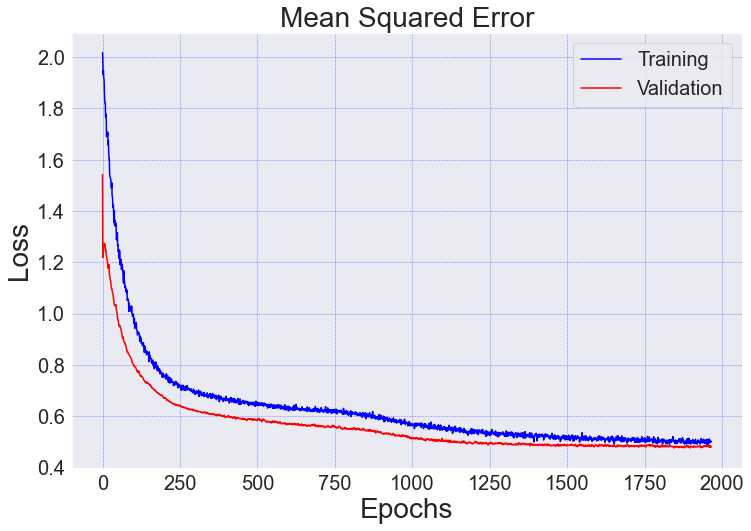

In [15]:
# ---------------------------------------------------------------------
# Training
# ---------------------------------------------------------------------

early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 120)

def training():
    history = model.fit(X_train, y_train,
                        batch_size = 32,
                        epochs = 10000,
                        validation_data = (X_test, y_test),
                        callbacks = [early_stop])
    return history

history = training()

model.save('teste2.model')

plt.figure(figsize = (12, 8))
plt.plot(history.history['mse'], label = 'Training', color = 'b')
plt.plot(history.history['val_mse'], label = 'Validation', color = 'r')
plt.title('Mean Squared Error', size = 28)
plt.xlabel('Epochs', size = 28)
plt.ylabel('Loss', size = 28)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.legend(fontsize = 20)
plt.grid(color = 'b', alpha = 0.5, linestyle = 'dashed', linewidth = 0.5)
plt.show()

In [40]:
# ---------------------------------------------------------------------
# Prediction
# ---------------------------------------------------------------------

model = tf.keras.models.load_model('teste2.model')
    
prediction = model.predict(X_test)
prediction.shape

(321, 5)

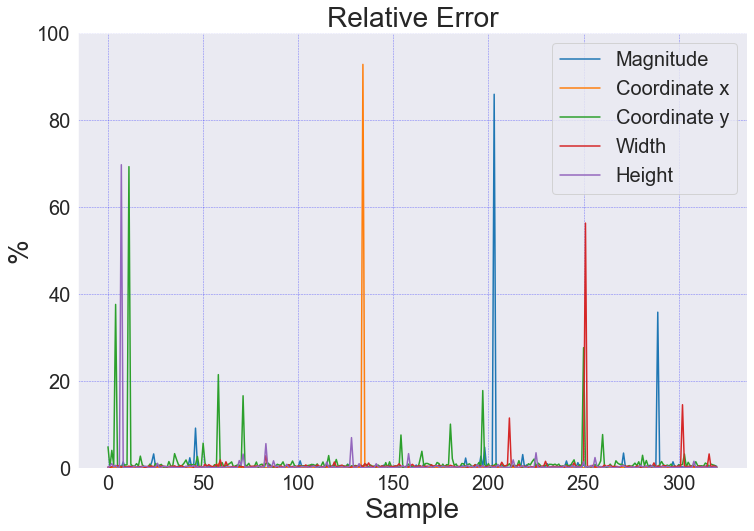

In [48]:
# ---------------------------------------------------------------------
# Predictions Evaluation
# ---------------------------------------------------------------------

relative_error = np.zeros(y_test.shape)

for ii in range(y_test.shape[0]):
    for jj in range(y_test.shape[1]):
        relative_error[ii, jj] = abs(prediction[ii, jj] - y_test[ii, jj]) / abs(y_test[ii, jj])

plt.figure(figsize = (12, 8))
plt.title('Relative Error', size = 28)
plt.plot(relative_error[:,0] * 100, label = 'Magnitude')
plt.plot(relative_error[:,1] * 100, label = 'Coordinate x')
plt.plot(relative_error[:,2] * 100, label = 'Coordinate y')
plt.plot(relative_error[:,3] * 100, label = 'Width')
plt.plot(relative_error[:,4] * 100, label = 'Height')
plt.xlabel('Sample', size = 28)
plt.ylabel('%', size = 28)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.legend(fontsize = 20)
plt.grid(color = 'b', alpha = 0.5, linestyle = 'dashed', linewidth = 0.5)
plt.ylim([0, 100])
plt.show()